# Milestone 2 Phase 2

Holla.. Irpan Habibi's here from Batch 004 Hacktiv8's Fulltime Data Science Programs

In This kernel I'm trying to implement **Computer vision** by making image classification using bird species datasets from kaggle. Computer vision is a field of artificial intelligence (AI) that enables computers and systems to derive meaningful information from digital images, videos and other visual inputs — and take actions or make recommendations based on that information. If AI enables computers to think, computer vision enables them to see, observe and understand.

**About Datasets:**

Link for datasets:https://www.kaggle.com/gpiosenka/100-bird-species

Data set of 315 bird species.45980 training images, 1575 test images(5 images per species) and 1575 validation images(5 images per species.
All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set.

## Import Libraries and Data Loading

In [1]:
#import necesary libraries 

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from keras.applications.vgg16 import decode_predictions, preprocess_input

os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import warnings
warnings.filterwarnings('ignore')

In [2]:
#for getting same result for any process
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#define train val and test data for loading
train_folder=r'train_set'
val_folder=r'val_set/'
test_folder=r'test_set/'

In [4]:
#show number of data train sets
import pathlib
data_dir = pathlib.Path(train_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2681


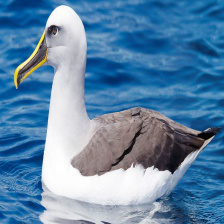

In [5]:
#view some image from datasets
albatross = list(data_dir.glob('ALBATROSS/*'))
PIL.Image.open(str(albatross[0]))

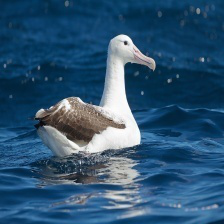

In [6]:
PIL.Image.open(str(albatross[2]))

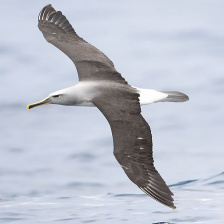

In [7]:
PIL.Image.open(str(albatross[3]))

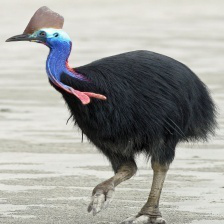

In [8]:
cassowary = list(data_dir.glob('CASSOWARY/*'))
PIL.Image.open(str(cassowary[0]))

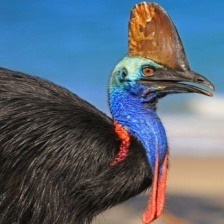

In [9]:
PIL.Image.open(str(cassowary[4]))

## Data Preprocessing

Before doing the modeling, it would be nice if we did the equalization of the data used for training and validation with some parameters that were made earlier, in this case the image size and the number of batches

In [10]:
IMG_WIDTH=224
IMG_HEIGHT=224
batch_size=4

In [11]:
#define train set and val set to show number of data will be train for classifying process

train_dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 2681 files belonging to 20 classes.


In [12]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 100 files belonging to 20 classes.


In [13]:
#define variable for classname from datasets
class_names = train_dataset.class_names
print(class_names)

['AFRICAN CROWNED CRANE', 'ALBATROSS', 'BALI STARLING', 'BARN SWALLOW', 'BEARDED BELLBIRD', 'BORNEAN PHEASANT', 'CALIFORNIA CONDOR', 'CANARY', 'CASSOWARY', 'CHARA DE COLLAR', 'FLAMINGO', 'GILA WOODPECKER', 'JAVA SPARROW', 'MALEO', 'MASKED BOOBY', 'OSPREY', 'PEREGRINE FALCON', 'PUFFIN', 'STRIPED OWL', 'YELLOW CACIQUE']


In [14]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(4, 224, 224, 3)
(4,)


Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.
- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [16]:
#normalization
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Model Building

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [18]:
#define first initial model using sequential API
num_classes = 20

model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [19]:
#compile model with adam optimizer 
#using loss with SparseCategoricalCrossentropy for multiclass
#metrics using 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [21]:
#model training

epochs=5

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/5
671/671 [==============================] - 125s 185ms/step - loss: 10.3418 - accuracy: 0.1253 - val_loss: 2.8099 - val_accuracy: 0.1400
Epoch 2/5
671/671 [==============================] - 125s 187ms/step - loss: 2.1239 - accuracy: 0.3711 - val_loss: 3.0745 - val_accuracy: 0.3300
Epoch 3/5
671/671 [==============================] - 124s 185ms/step - loss: 1.0959 - accuracy: 0.6848 - val_loss: 3.6232 - val_accuracy: 0.2600
Epoch 4/5
671/671 [==============================] - 123s 183ms/step - loss: 0.6831 - accuracy: 0.8161 - val_loss: 3.8592 - val_accuracy: 0.2600
Epoch 5/5
671/671 [==============================] - 141s 210ms/step - loss: 0.6482 - accuracy: 0.8471 - val_loss: 4.6683 - val_accuracy: 0.2600


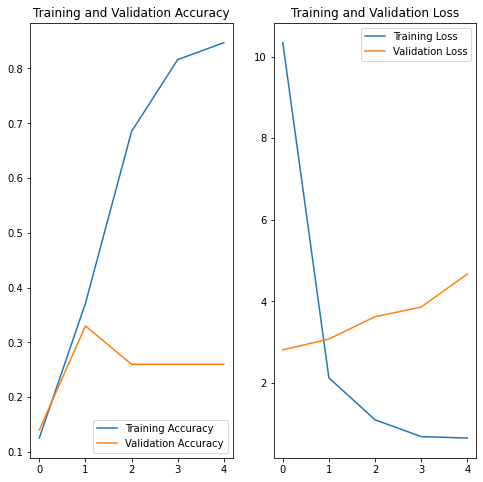

In [22]:
# model evaluating with visualizing accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the curve we can see that this model is included in the **overfitting** model, this is indicated by the validation accuracy which is significantly different from the training accuracy. So for the next, to prevent overfitting of the model, I tried **data augmentation** and insert dropouts on the last layer. 

There are several things to do in data augmentation such as **randomflip, randomzoom and randomrotate**

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [24]:
#re-define model within dropout layer
model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

In [27]:
epochs = 10
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10
671/671 [==============================] - 136s 199ms/step - loss: 6.4800 - accuracy: 0.0828 - val_loss: 2.9620 - val_accuracy: 0.0700
Epoch 2/10
671/671 [==============================] - 140s 209ms/step - loss: 2.9412 - accuracy: 0.0906 - val_loss: 2.8386 - val_accuracy: 0.1600
Epoch 3/10
671/671 [==============================] - 135s 202ms/step - loss: 2.8919 - accuracy: 0.1216 - val_loss: 2.8246 - val_accuracy: 0.0900
Epoch 4/10
671/671 [==============================] - 137s 204ms/step - loss: 2.8268 - accuracy: 0.1406 - val_loss: 2.7866 - val_accuracy: 0.1600
Epoch 5/10
671/671 [==============================] - 139s 207ms/step - loss: 2.6784 - accuracy: 0.1921 - val_loss: 2.8535 - val_accuracy: 0.2100
Epoch 6/10
671/671 [==============================] - 139s 207ms/step - loss: 2.5597 - accuracy: 0.2305 - val_loss: 2.3023 - val_accuracy: 0.2600
Epoch 7/10
671/671 [==============================] - 139s 206ms/step - loss: 2.3312 - accuracy: 0.2932 - val_loss: 2.4718 -

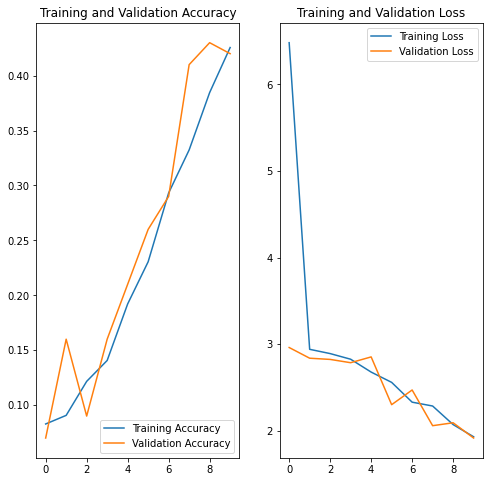

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After training for the second time with the same model using augmentation data and entering dropouts on the layer, the accuracy results on the curve show that there is no overfitting but the accuracy results are still low and can still be improved.

Before continuing to improvise the model, it would be better if we try to do a test prediction on the model that has been made using the test data that has been prepared for the inference model.

In [29]:
#load data test for model inference
test_image = r'test_set/ALBATROSS/1.jpg'

img = keras.preprocessing.image.load_img(
    test_image, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

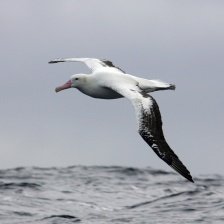

In [30]:
img

In [31]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to ALBATROSS with a 15.98 percent confidence.


predictions using test data showed correct results when doing the classification, but the confidence percentage which was quite low made me assume that the model still could not be used to predict a new data.

## Transfer Learning and Fine Tuning

### MobileNetV2

MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. There are two simple global hyper-parameters that efficiently trade off between latency and accuracy. These hyper-parameters allow the model builder to choose the right sized model for their application based on the constraints of the problem.

In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

The first thing I did before creating the model was to define the base model using mobilenetv2 with some parameters. One of them is imagenet. ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories.

In [41]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [42]:
base_model.trainable = False

In [43]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20)

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [46]:
#define model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_MobileNetV2 = tf.keras.Model(inputs, outputs)

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [47]:
base_learning_rate = 0.0001

model_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

I run a training model with 50 epochs and implement callbacks to make it more efficient. 

In [49]:
#train model
epochs = 50
history = model_MobileNetV2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7,
                                 patience = 2, verbose = 1)])

Epoch 1/50
671/671 [==============================] - 112s 162ms/step - loss: 2.0324 - accuracy: 0.4386 - val_loss: 1.0564 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 2/50
671/671 [==============================] - 114s 170ms/step - loss: 0.8949 - accuracy: 0.8232 - val_loss: 0.5005 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 3/50
671/671 [==============================] - 111s 165ms/step - loss: 0.5332 - accuracy: 0.9034 - val_loss: 0.3019 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 4/50
671/671 [==============================] - 114s 170ms/step - loss: 0.3795 - accuracy: 0.9288 - val_loss: 0.2060 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 5/50
671/671 [==============================] - 110s 164ms/step - loss: 0.2931 - accuracy: 0.9500 - val_loss: 0.1588 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 6/50
671/671 [==============================] - 1243s 2s/step - loss: 0.2466 - accuracy: 0.9467 - val_loss: 0.1211 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 7/50
671/671 [====

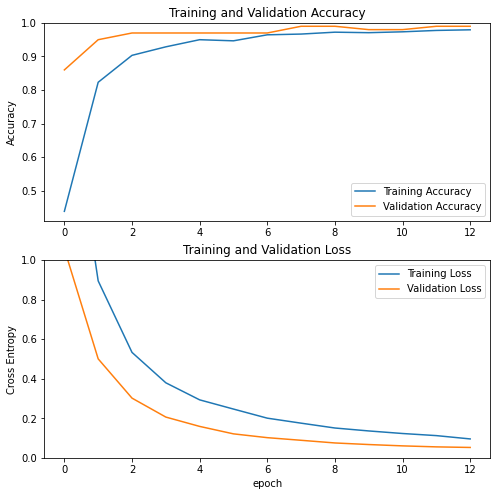

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

as we can see in the curve, train accuracy and val accuracy show that the model is quite good with insignificant differences so that it does not show overfitting. 

In [51]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    batch_size = batch_size,
    image_size = (IMG_HEIGHT, IMG_WIDTH))

Found 100 files belonging to 20 classes.


In [52]:
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [53]:
model_MobileNetV2.evaluate(test_dataset)

25/25 [==============================] - 4s 139ms/step - loss: 0.0921 - accuracy: 0.9800


[0.09213332086801529, 0.9800000190734863]

the evaluation results show a very good model indicated by a very low loss then a fairly high accuracy. Therefore, I will try to do an inference model using test data that has been prepared to be predicted using this model

In [54]:
test_image = r'test_set/GILA WOODPECKER/1.jpg'

img = keras.preprocessing.image.load_img(
    test_image, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

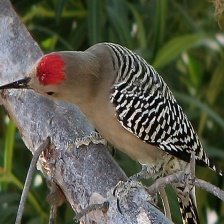

In [55]:
img

In [56]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_MobileNetV2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to GILA WOODPECKER with a 97.43 percent confidence.


This prediction shows accurate results with a confidence percentage of 97.43. And then I'll save this model.

In [57]:
model_MobileNetV2.save("model_base_MobileNetV2.h5")

### Fine Tuning 

Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [58]:
base_model.trainable = True

In [59]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [60]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [61]:
model_MobileNetV2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [62]:
model_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

as we can see in the model summary above that there are some differences from before fine tuning, especially the number of trainable parameters. Then I will continue training this model with 10 epochs and keep using callbacks

In [67]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model_MobileNetV2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7,
                                 patience = 2, verbose = 1)]
                        )

Epoch 13/60
671/671 [==============================] - 197s 287ms/step - loss: 0.1205 - accuracy: 0.9593 - val_loss: 0.0496 - val_accuracy: 0.9900 - lr: 1.0000e-05
Epoch 14/60
671/671 [==============================] - 190s 283ms/step - loss: 0.0899 - accuracy: 0.9717 - val_loss: 0.0320 - val_accuracy: 0.9800 - lr: 1.0000e-05
Epoch 15/60
671/671 [==============================] - 191s 285ms/step - loss: 0.0633 - accuracy: 0.9765 - val_loss: 0.0648 - val_accuracy: 0.9800 - lr: 1.0000e-05
Epoch 16/60
671/671 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9847
Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.9999998231651255e-06.
671/671 [==============================] - 189s 281ms/step - loss: 0.0483 - accuracy: 0.9847 - val_loss: 0.0336 - val_accuracy: 0.9900 - lr: 1.0000e-05
Epoch 17/60
671/671 [==============================] - 195s 290ms/step - loss: 0.0388 - accuracy: 0.9862 - val_loss: 0.0142 - val_accuracy: 0.9900 - lr: 7.0000e-06
Epoch 18/60
67

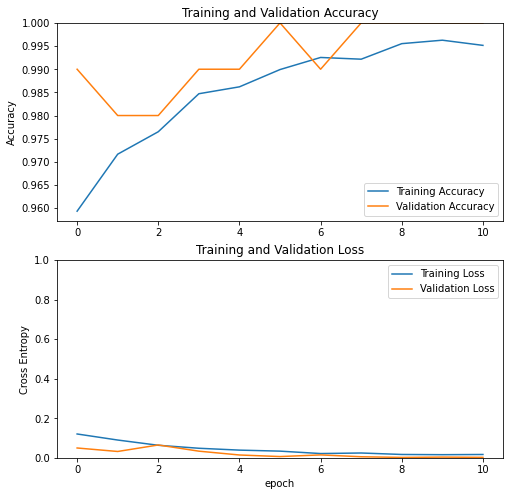

In [68]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [69]:
model_MobileNetV2.evaluate(test_dataset)

25/25 [==============================] - 4s 171ms/step - loss: 0.0440 - accuracy: 0.9700


[0.04404280334711075, 0.9700000286102295]

After fine tuning the model shows that there is an increase in accuracy as well as a decrease in loss. Therefore, let's try again doing the inference model to predict the test data that has been prepared

In [70]:
test_image = r'test_set/MASKED BOOBY/1.jpg'

img = keras.preprocessing.image.load_img(
    test_image, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

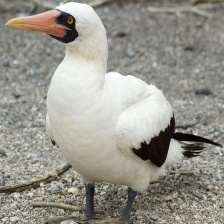

In [71]:
img

In [72]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_MobileNetV2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to MASKED BOOBY with a 99.97 percent confidence.


## Overall Analysis

In this kernel I am trying to do image classification using bird species data. In this dataset, I use 20 bird species to label this classification. In general, these datasets have been prepared for the implementation of Computer Vision so that when used there are no problems at all on the datasets.

There are approximately 2000 images to be used as train data, then for test data and validation data there are 100 each. This number is relatively small because I only use a small part of the overall datasets with computational goals that are not too high. All images in this data have dimensions of 224 x 224 x 3 with .jpg format. The test and validation images in the data set were hand selected to be the "best" images so your model will probably get the highest accuracy score using those data sets versus creating your own test and validation sets. However the latter case is more accurate in terms of model performance on unseen images.

**Model Analysis**


- The first model that I made showed a quaite good results on train accuracy but there was overfitting. Due to overfitting then I apply augmentation data for model improvement and add dropout. Then after training, the model does not show overfitting but the accuracy value is not too good. To make sure I tried to make predictions on the test data and the results were correct with low accuracy confidence.
- For the second model, I tried to implement transfer learning using mobilenetv2 as the base model to be used. Based on the reference, this mobilnet has a very good architecture to be applied in image classification. Before defining the model I freeze the base layer so that the number of weight doesn't change and I only do training on the output layer. After training the model, I got quite good accuracy and loss results. Then to improve the model I tried to do fine tuning by unfreezing some layers for further training. I evaluated the model with the following final results: Loss 0.04, Accuracy 0.97
